In [9]:
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import torch

from torch import optim

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from dataset.dataset_batcher import SlimDataset

from models.SLIM import SLIM
from dataset.preprocessing import get_mini_batch
from helpers.train_helper import Trainer

from helpers.scheduler import LinearDecayLR


 ### Imports

In [10]:
# source: https://github.com/NVIDIA/framework-determinism/blob/master/pytorch.md

import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
CUDA_LAUNCH_BLOCKING = 1


 ### Initialize some variables


In [11]:
dataset_dir = "/scratch/guszarzmo/aicsproject/data/slim/turk_data_torch/"
model_path = "/scratch/guszarzmo/aicsproject/checkpoints/transf_encr_dec/simplelstm_z128_1e3/"
model_name = "slim_13-06-07h28_1300999.pt"

file_batch = 1

views_emb_size = 4
image_width = 64
image_height = 64
image_color = 3


CAPTION_ENC_SZ = 64
VIEWS_ENC_SZ = 32
SC_r_SZ = 64
ITER_NUM = 8
DRAW_h_SZ = 128
DRAW_Z_SZ = 128


model_parameters = {
    "caption_embs_size": CAPTION_ENC_SZ,
    "views_emb_size": views_emb_size,
    "views_enc_size": VIEWS_ENC_SZ,
    "scene_rep_size": SC_r_SZ,
    "image_width": image_width,
    "image_height": image_height,
    "image_color": image_color,
    "iter_num": ITER_NUM,
    "draw_h_size": DRAW_h_SZ,
    "z_size": DRAW_Z_SZ,
}


 ### Auotomatic GPU selection

In [12]:
# Select cuda device based on the free memory
# Most of the time some cudas are busy but available
# torch.cuda.empty_cache()
use_cpu = False
prefered_device = 1

if prefered_device is None:
    from utils.gpu_cuda_helper import get_gpus_avail

    cuda_idx = get_gpus_avail()
    device = None
    if not cuda_idx:
        device = torch.device("cpu")
    elif len(cuda_idx) >= 1:
        cuda_id = cuda_idx[0][0]
        if cuda_id == 0:
            cuda_id = cuda_idx[1][0]
        device = torch.device(f"cuda:{cuda_id}")
else:
    device = torch.device(prefered_device)
    

if use_cpu:
    device = torch.device("cpu")

print(f"\ndevice selected: {device}")



device selected: cuda:1


 ### Initialize plotting class

 ### DataLoader

In [13]:

test_dataset = SlimDataset(root_dir=dataset_dir + "test")
test_iter = DataLoader(test_dataset,
                       batch_size=file_batch,
                       shuffle=True)


### Calculate images mean and std variance 

In [14]:
# train_dataset = SlimDataset(root_dir=dataset_dir + "train")
# val_dataset = SlimDataset(root_dir=dataset_dir + "valid")
# all_datasets = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
# all_iter = DataLoader(all_datasets, batch_size=64, shuffle=False) 

# # calc mean and std
# nimages = 0
# mean = 0.0
# var = 0.0
# for i, batch in enumerate(all_datasets):
#     images = batch[0]
#     # Rearrange batch to be the shape of [B, C, W * H]
#     images = images.view(images.size(0)*images.size(1), images.size(2), -1)
#     # Update total number of images
#     nimages += images.size(0)
#     # Compute mean and std here
#     mean += images.mean(2).sum(0) 
#     var += images.var(2).sum(0)

# mean /= nimages
# var /= nimages
# std = torch.sqrt(var)

# print(mean)
# print(std)

 ### Construct the model

 ### Load the best model

In [15]:

# change device

load_path = model_path + model_name
model_data = torch.load(load_path, map_location=device)
model_state_dict = model_data["model_state_dict"]

model_inference = SLIM(model_parameters)
model_inference = model_inference.to(device)
model_inference.load_state_dict(model_state_dict)



<All keys matched successfully>

### Tesing Model

In [16]:
import pandas as pd

model_inference.eval()
test_loss = []
images_r = []
images_g = []
images_t = []
tokens_id_context = []
attention_mask_context = []
view_image = []
views = []
test_steps = 0

with tqdm(test_iter, unit="file") as testpb:
    for test_batch in testpb:
        test_mini_batches = get_mini_batch(
            data=test_batch, size_=1)
        
        for mini_batch in test_mini_batches:
            testpb.set_description(f"Testing Step {test_steps}")
            with torch.no_grad():
                image, loss, (_, _) = model_inference(mini_batch, 0)
                # generate image
                images_r.append(image.cpu())
                image_g = model_inference.generate(mini_batch)
                images_g.append(image_g.cpu())
                images_t.append(mini_batch[0])
                tokens_id_context.append(mini_batch[3])
                attention_mask_context.append(mini_batch[4])
                view_image.append(mini_batch[1])
                views.append(mini_batch[2]) 
                
                test_loss.append(loss.item())
                test_steps += 1
data_dict = {"GroundTruth": images_t,
             "ImageGen": images_g,
             "ImageRecon": images_r,
             "ImageView": view_image,
             "SceneViews": views,
             "tokens_id": tokens_id_context,
             "tokens_mask": attention_mask_context,
             "loss": test_loss}

test_df =  pd.DataFrame(data_dict)
test_df.index.name = "serial"

ipykernel_launcher:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/9 [00:00<?, ?file/s]

### Loss Calculation

In [17]:
test_loss = np.array(test_loss)
loss_average = np.mean(test_loss)
loss_res = np.std(test_loss)
max_loss = np.max(test_loss)
min_loss = np.min(test_loss)

print(f"minimum loss: {min_loss:.3f}")
print(f"maximum loss: {max_loss:.3f}")
print(f"loss:         {loss_average:.2f} \u00B1 {loss_res:0.2f}")


minimum loss: 27.292
maximum loss: 254.583
loss:         74.50 ± 30.78


### PLot Images

In [18]:
from torchvision.utils import make_grid

def plot_grid(df):
    plt.figure(figsize=(20, 12))

    plt.subplot(311)
    img = torch.squeeze(torch.stack(df.GroundTruth.to_list())).cpu()
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Ground Truth")

    plt.subplot(312)
    img = torch.squeeze(torch.stack(df.ImageRecon.to_list())).cpu()
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Reconstructed")

    plt.subplot(313)
    img = torch.squeeze(torch.stack(df.ImageGen.to_list())).cpu()
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Generated")


    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


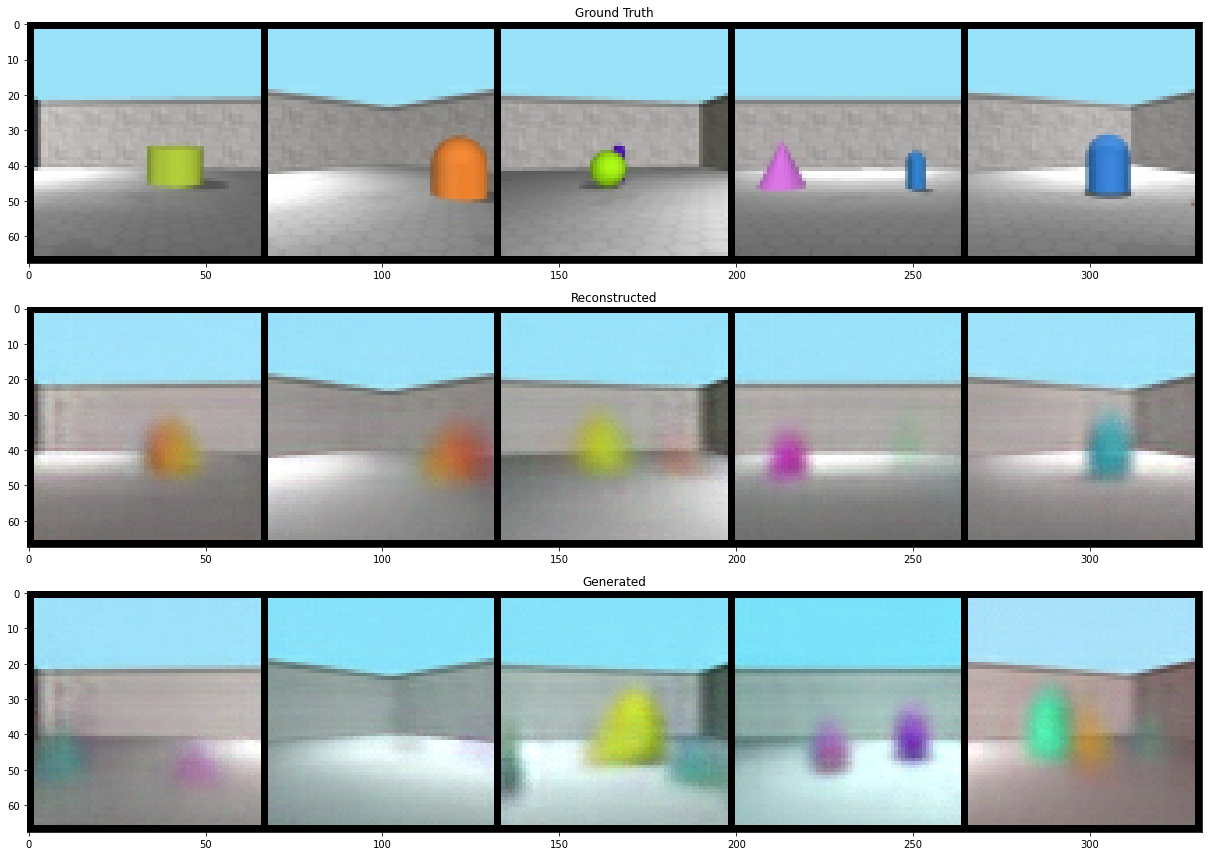

In [19]:
best_samples_df = test_df.nsmallest(5, 'loss', keep='all')
plot_grid(best_samples_df)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


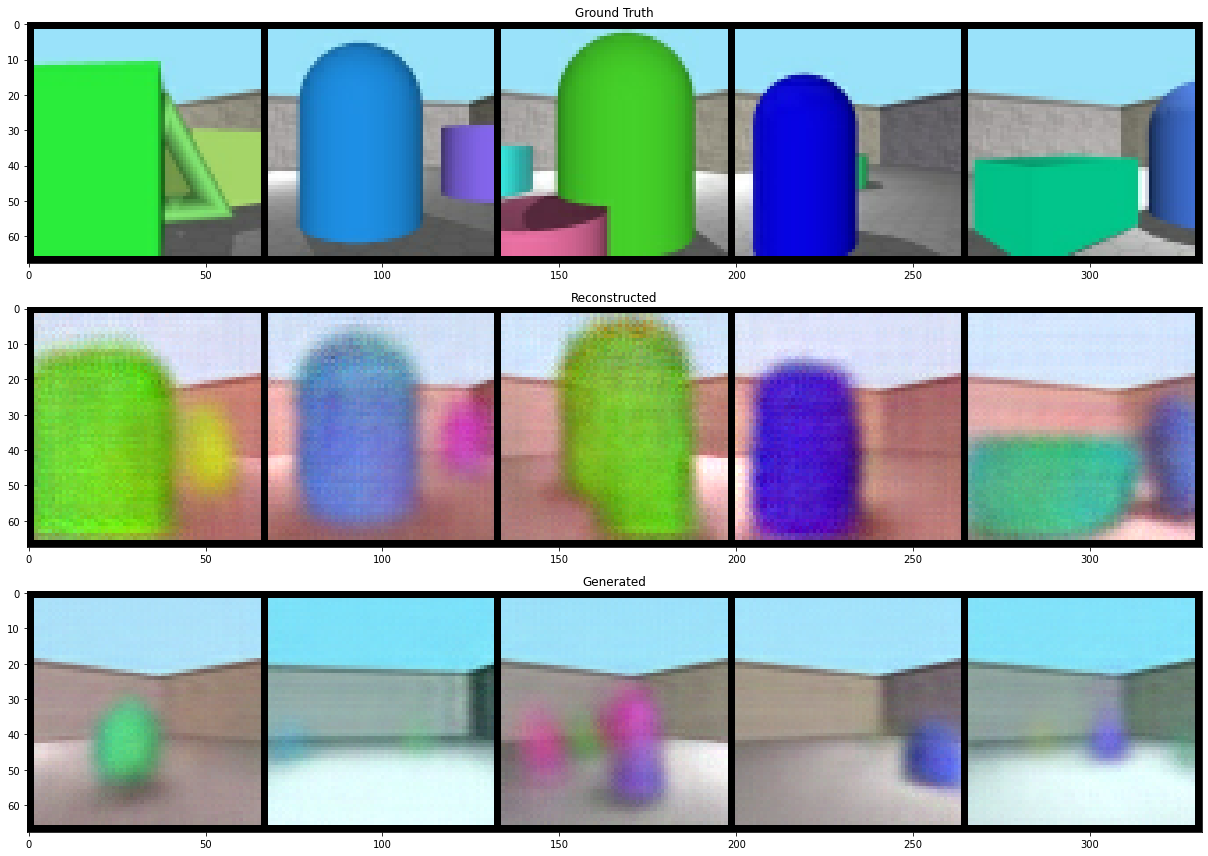

In [20]:
worst_samples_df = test_df.nlargest(5, 'loss', keep='all')
plot_grid(worst_samples_df)

### Change Views

In [21]:
j = random.randint(0,8) 
data_id = 4
image_true = best_samples_df.GroundTruth.to_list()[data_id]
image_vw = best_samples_df.ImageView.to_list()[data_id]
views_other = best_samples_df.SceneViews.to_list()[data_id]
tokens_id = best_samples_df.tokens_id.to_list()[data_id]
tokens_mask = best_samples_df.tokens_mask.to_list()[data_id]

images_g = []
images_r = []
for j in tqdm(range(9)):
    views_other_ = views_other[:, j, :].view(1, 1, -1)
    tokens_id_random = tokens_id[:, j, :].view(1, 1, -1)
    tokens_mask_random = tokens_mask[:, j, :].view(1, 1, -1)
    mybatch = [image_true, image_vw, views_other_, tokens_id_random, tokens_mask_random]
    image, loss, (_, _) = model_inference(mybatch, 0)
    image_g = model_inference.generate(mini_batch)

    images_r.append(image.cpu())
    images_g.append(image_g.cpu())


ipykernel_launcher:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/9 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Generated')

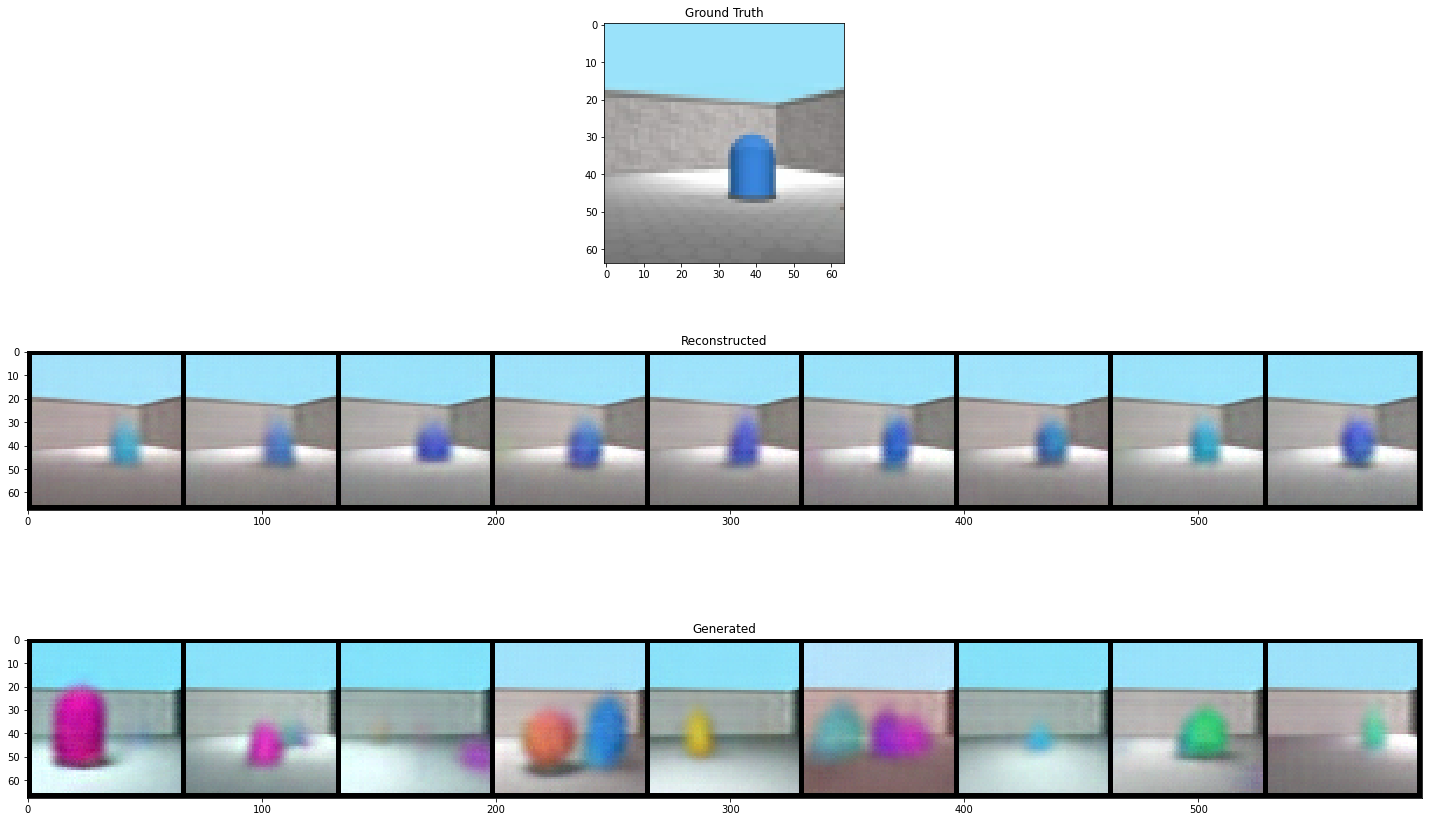

In [22]:
plt.figure(figsize=(25, 15))

plt.subplot(311)
img = image_true.cpu()
grid = make_grid(img).permute(1, 2, 0).numpy()
plt.imshow(grid, interpolation="nearest")
plt.title("Ground Truth")

plt.subplot(312)
img = torch.squeeze(torch.stack(images_r)).cpu()
grid = make_grid(img, nrow=9).permute(1, 2, 0).detach().numpy()
plt.imshow(grid, interpolation="nearest")
plt.title("Reconstructed")

plt.subplot(313)
img = torch.squeeze(torch.stack(images_g)).cpu()
grid = make_grid(img, nrow=9).permute(1, 2, 0).detach().numpy()
plt.imshow(grid, interpolation="nearest")
plt.title("Generated")